## CRNN_crop_stft

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

filename1 = '/content/gdrive/My Drive/Colab Notebooks/EEG'
filename2 = '/content/gdrive/My Drive/Final Project/project_data'
filename3 = '/content/gdrive/My Drive/UCLA/239AS/Final Project/project_data'
filename4 = '/content/gdrive/My Drive/UCLA/239AS/Final Project/project_data'

os.chdir(filename2)
#os.chdir('/content/gdrive/My Drive/Colab Notebooks/EEG')

# USE GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Found GPU at: /device:GPU:0


## Loading and Preprocessing

In [0]:
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib import pyplot as plt

np.random.seed(0)

Using TensorFlow backend.


In [0]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, LSTM, Activation
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, ELU, ReLU
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
np.random.seed(0)


X_test_raw = np.load("X_test.npy")[:,:22,:]
y_test_raw = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid_raw = np.load("X_train_valid.npy")[:,:22,:]
y_train_valid_raw = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

print ('Training/Valid data shape: {}'.format(X_train_valid_raw.shape))
print ('Test data shape: {}'.format(X_test_raw.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid_raw.shape))
print ('Test target shape: {}'.format(y_test_raw.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
# Spliting data w.r.t 9 subjects, Store them in X_train_set, y_train_set, X_test_set, y_test_set
num_subject = 9
num_train_data, num_test_data = y_train_valid_raw.shape[0], y_test_raw.shape[0]
X_train_set, X_test_set = [], []
y_train_set , y_test_set = [], []
for subject in range(num_subject):
    X_sub_train = []
    y_sub_train = []
    X_sub_test = []
    y_sub_test = []
    for i in range(num_train_data):
        if person_train_valid[i] == subject:
            X_sub_train.append(X_train_valid_raw[i])
            y_sub_train.append(y_train_valid_raw[i])
    X_sub_train = np.array(X_sub_train)
    y_sub_train = np.array(y_sub_train)
    X_train_set.append(X_sub_train)
    y_train_set.append(y_sub_train)
    
    for i in range(num_test_data):
        if person_test[i] == subject:
            X_sub_test.append(X_test_raw[i])
            y_sub_test.append(y_test_raw[i])
    X_sub_test = np.array(X_sub_test)
    y_sub_test = np.array(y_sub_test)
    X_test_set.append(X_sub_test)
    y_test_set.append(y_sub_test)
    
    print("subject {} has {} training data and {} testing data".format(subject, len(y_sub_train), len(y_sub_test)))


subject 0 has 237 training data and 50 testing data
subject 1 has 236 training data and 50 testing data
subject 2 has 236 training data and 50 testing data
subject 3 has 234 training data and 50 testing data
subject 4 has 235 training data and 47 testing data
subject 5 has 236 training data and 49 testing data
subject 6 has 238 training data and 50 testing data
subject 7 has 232 training data and 50 testing data
subject 8 has 231 training data and 47 testing data


In [0]:
# Cropping
def crop(X_train_set, X_test_set, y_train_set, y_test_set, crop_size=750, stride=30):
  
  num_subject = 9
  # crop on training
  X_train_crop = []
  y_train_crop = []
  for idx, X in enumerate(X_train_set):
    crop_train = []
    num_train = X.shape[0]
    for i in range((X.shape[2] - crop_size)//stride + 1):
      crop_train.append(X[:,:,i*stride:i*stride+crop_size])
    
    y_train_crop.append(np.stack(np.tile(y_train_set[idx], i+1), axis=0))
    X_train_crop.append(np.concatenate(crop_train, axis=0))
    
    print("subject {} has training data shape of {} and training label of shape {}".format(idx, X_train_crop[idx].shape, y_train_crop[idx].shape))
    
    
  # crop on testing
  
  X_test_crop = []
  y_test_crop = []
  for idx, X in enumerate(X_test_set):
    crop_test = []
    num_test = X.shape[0]
    for i in range((X.shape[2] - crop_size)//stride + 1):
      crop_test.append(X[:,:,i*stride:i*stride+crop_size])
    
    y_test_crop.append(np.stack(np.tile(y_test_set[idx], i+1), axis=0))
    X_test_crop.append(np.concatenate(crop_test, axis=0))
    
    
  
    print("subject {} has testing data shape of {} and testing label shape of{}".format(idx, X_test_crop[idx].shape, y_test_crop[idx].shape))
    
  
  return X_train_crop, X_test_crop, y_train_crop, y_test_crop
    
  
    
    
      
    
    
X_train_crop, X_test_crop, y_train_crop, y_test_crop = crop(X_train_set, X_test_set, y_train_set, y_test_set)

  

subject 0 has training data shape of (2133, 22, 750) and training label of shape (2133,)
subject 1 has training data shape of (2124, 22, 750) and training label of shape (2124,)
subject 2 has training data shape of (2124, 22, 750) and training label of shape (2124,)
subject 3 has training data shape of (2106, 22, 750) and training label of shape (2106,)
subject 4 has training data shape of (2115, 22, 750) and training label of shape (2115,)
subject 5 has training data shape of (2124, 22, 750) and training label of shape (2124,)
subject 6 has training data shape of (2142, 22, 750) and training label of shape (2142,)
subject 7 has training data shape of (2088, 22, 750) and training label of shape (2088,)
subject 8 has training data shape of (2079, 22, 750) and training label of shape (2079,)
subject 0 has testing data shape of (450, 22, 750) and testing label shape of(450,)
subject 1 has testing data shape of (450, 22, 750) and testing label shape of(450,)
subject 2 has testing data shap

## Short Time Fourier Transform

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


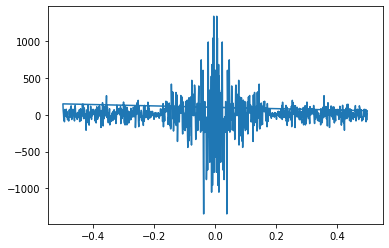

In [0]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(1000, d = 1)
sig_fft = fftpack.fft(X_train_valid_raw[0][0])


plt.plot(sample_freq, sig_fft)
plt.show()


In [0]:
sample_freq[999]

-0.001

In [0]:
import scipy as sp
spec = abs(sp.fft(X_train_valid_raw[0][0]))
plt.plot(spec)
plt.show()

In [0]:
from scipy.signal import stft

# perform STFT on data so that we can see the magnitude of signal w.r.t. both time and frequency
def STFT(data, seg=128, overlap=76, crop_size=8):
  f, t, zxx = stft(data, nperseg=seg, noverlap=overlap)
  new_data = np.abs(zxx)
  f_crop = f[:seg//crop_size]
  t_crop = t[:]
  new_data_crop = new_data[:, :, :seg//crop_size, :]
  print("new data shape: {}".format(new_data_crop.shape))
  return f_crop, t_crop, new_data_crop



In [0]:
from scipy.signal import stft

# perform STFT on data so that we can see the magnitude of signal w.r.t. both time and frequency
def STFT_no_filter(data, seg=128, overlap=76, crop_size=8):
  f, t, zxx = stft(data, nperseg=seg, noverlap=overlap)
  new_data = np.abs(zxx)
  f_crop = f[:]
  t_crop = t[:]
  new_data_crop = new_data[:, :, :, :]
  print("new data shape: {}".format(new_data_crop.shape))
  return f_crop, t_crop, new_data_crop



In [0]:
# stft on subject 0
X_train_valid = {}
X_test = {}
y_train_valid = {}
y_test = {}
f,t,X_train_valid[0] = STFT_no_filter(X_train_crop[0])
f,t,X_test[0] = STFT_no_filter(X_test_crop[0])
y_train_valid[0] = y_train_crop[0]
y_test[0] = y_test_crop[0]


NameError: ignored

In [0]:
X_train_valid[0][128,5,:,:].shape

KeyError: ignored

In [0]:
import matplotlib.pyplot as plt
plt.plot(X_train_valid[0][128,5,:,:])
plt.show()

KeyError: ignored

(65, 16)


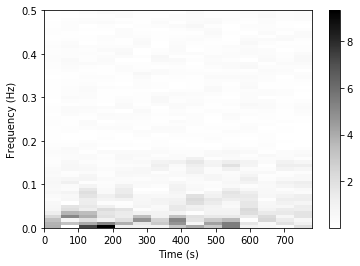

(65, 16)


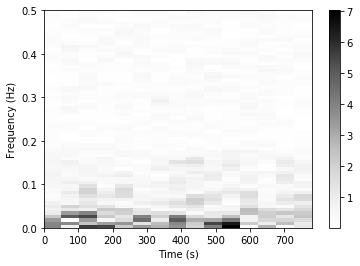

In [0]:
# show an example of STFT result, We can map each temporal data to a picture with size (time, frequency). Then we can apply CNN
import matplotlib.pyplot as plt


example = X_train_valid[0][128,5,:,:]
print(example.shape)
plt.pcolormesh(t, f, example, cmap = plt.cm.Greys)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel("Frequency (Hz)")
plt.show()

example = X_train_valid[0][128,0,:,:]
print(example.shape)
plt.pcolormesh(t, f, example, cmap = plt.cm.Greys)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel("Frequency (Hz)")
plt.show()

In [0]:
# stft on subject 0
X_train_valid = {}
X_test = {}
y_train_valid = {}
y_test = {}
f,t,X_train_valid[0] = STFT(X_train_crop[0])
f,t,X_test[0] = STFT(X_test_crop[0])
y_train_valid[0] = y_train_crop[0]
y_test[0] = y_test_crop[0]


new data shape: (2133, 22, 16, 16)
new data shape: (450, 22, 16, 16)


(16, 16)


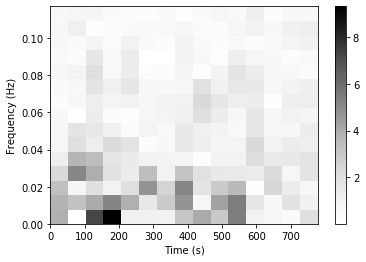

(16, 16)


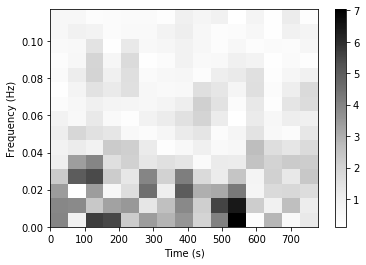

In [0]:
# show an example of STFT result, We can map each temporal data to a picture with size (time, frequency). Then we can apply CNN
import matplotlib.pyplot as plt


example = X_train_valid[0][128,5,:,:]
print(example.shape)
plt.pcolormesh(t, f, example, cmap = plt.cm.Greys)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel("Frequency (Hz)")
plt.show()

example = X_train_valid[0][128,0,:,:]
print(example.shape)
plt.pcolormesh(t, f, example, cmap = plt.cm.Greys)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel("Frequency (Hz)")
plt.show()

## CRNN

### CRNN-cascade

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization,\
Activation, Flatten, Dense, Dropout, LSTM, Input, TimeDistributed
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization

def one_hot_matrix(labels, C=4):
    transformed_labels = labels - 769
    C = tf.constant(C, name = "C")
    one_hot_matrix = tf.one_hot(transformed_labels, depth = C, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

# CRNN in cascade, feed the CNN output into the RNN
def CRNN_cascade_Model(input_shape):
  tf.set_random_seed(2)
  np.random.seed(2)
  
  # CNN
  X_input = Input(input_shape)  
  X = Conv2D(filters = 22, kernel_size = (3, 3), strides = (1, 1), kernel_regularizer=regularizers.l1(0.01), 
                   name = 'conv0', data_format='channels_last')(X_input)
  X = Conv2D(filters= 44, kernel_size = (3, 3), strides = (1, 1), name = 'conv1', data_format='channels_last', 
                   padding='valid', kernel_regularizer=regularizers.l2(0.01))(X) 
  X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'mean_pool')(X)
  X = ELU()(X)
  #X = BatchNormalization()(X)
  #X = Dropout(0.5)(X)
  X = Flatten()(X)
  X = Dropout(0.5, seed = 0)(X)
  X = Dense(units = 1000, activation='elu', name='fc1')(X)
  X = BatchNormalization()(X)
  X = Dropout(0.8, seed = 0)(X)
  X = Dense(units = 32, activation='elu', name='fc2')(X) 
  print(X.shape)
  
  # Reshape the tensor for RNN
  XR = Reshape((X.shape[1], 1))(X)
  
  # RNN  
  XR = LSTM(units = 32, return_sequences = False, kernel_regularizer=regularizers.l2(0.01))(XR)    
  XR = Dropout(0.5, seed = 0)(XR)  
  
  
  X_out = Dense(units = 4, activation='softmax', name='fc_last')(XR)
  
  model = Model(inputs = X_input, outputs = X_out, name='CRNN_cascade_Model')  
 
  return model


In [0]:
subject_num = 0
y_train_onehot = one_hot_matrix(y_train_valid[subject_num])
y_train_onehot = y_train_onehot.T
N, C, F, T = X_train_valid[subject_num].shape
print("Training data shape: {}".format(X_train_valid[subject_num].shape))


Training data shape: (2133, 22, 16, 16)


In [0]:
import time
start = time.time()
model = CRNN_cascade_Model(input_shape = (C, F, T))
optimizer = optimizers.Adam(lr=0.2)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x = X_train_valid[0], y = y_train_onehot, 
                    epochs = 40, batch_size = 20, 
                    validation_split = 0.2, verbose = 0)
end = time.time()


(?, 32)


In [0]:
print(X_test[0].shape)
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
preds = model.evaluate(x = X_test[0],y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

(450, 22, 16, 16)
450/450 [==============================] - 0s 694us/sample - loss: 1.4797 - acc: 0.5689
Loss = 1.4797073205312092
Test Accuracy = 0.5688889


In [0]:
print(end-start)

238.7122220993042


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


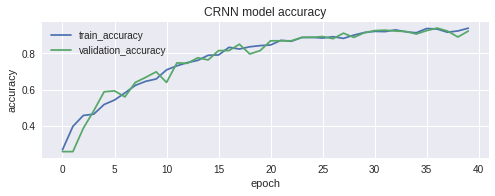

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('CRNN model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

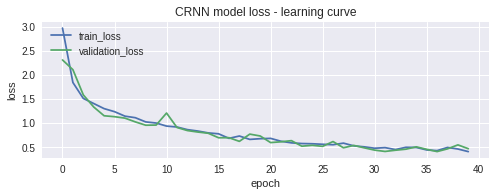

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('CRNN model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

### CRNN-cascade for All Subjects

In [0]:
X_train_valid_all=X_train_valid[0]
for i in np.arange(1,9):
  _,_,X_train_valid[i] = STFT(X_train_crop[i])  
  X_train_valid_all = np.concatenate((X_train_valid_all, X_train_valid[i]), axis=0)
  
print(X_train_valid_all.shape)

new data shape: (2124, 22, 16, 16)
new data shape: (2124, 22, 16, 16)
new data shape: (2106, 22, 16, 16)
new data shape: (2115, 22, 16, 16)
new data shape: (2124, 22, 16, 16)
new data shape: (2142, 22, 16, 16)
new data shape: (2088, 22, 16, 16)
new data shape: (2079, 22, 16, 16)
(19035, 22, 16, 16)


In [0]:
y_train_valid_all=y_train_crop[0]
for i in np.arange(1,9):
  y_train_valid_all = np.concatenate((y_train_valid_all, y_train_crop[i]), axis=0)

print(y_train_valid_all.shape)

(19035,)


In [0]:
y_train_all_onehot = one_hot_matrix(y_train_valid_all)
y_train_all_onehot = y_train_all_onehot.T
N, C, F, T = X_train_valid_all.shape
print("Training data shape: {}".format(X_train_valid_all.shape))

Training data shape: (19035, 22, 16, 16)


In [0]:
model = CRNN_cascade_Model(input_shape = (C, F, T))
optimizer = optimizers.Adam(lr=0.5)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x = X_train_valid_all, y = y_train_all_onehot, 
                    epochs = 30, batch_size = 1024, 
                    validation_split = 0.2, shuffle = 1, verbose = 0)  

(?, 32)


In [0]:
print(X_test[0].shape)
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
preds = model.evaluate(x = X_test[0],y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

(450, 22, 16, 16)
450/450 [==============================] - 0s 805us/sample - loss: 1.1315 - acc: 0.5333
Loss = 1.1314706293741863
Test Accuracy = 0.53333336


In [0]:
import keras.backend as K
def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.


# .... Define your model here ....
print(get_flops(CRNN_cascade_Model))




Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
9937802


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


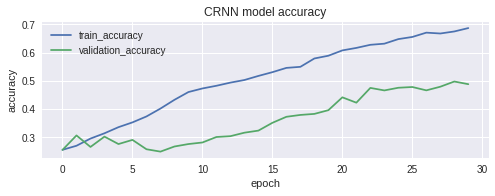

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('CRNN model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

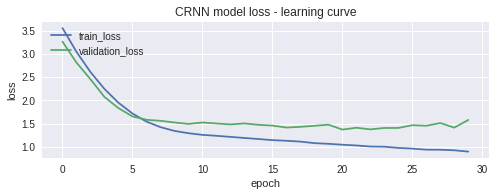

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('CRNN model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

### CRNN-parallel

In [0]:
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential

def one_hot_matrix(labels, C=4):
    transformed_labels = labels - 769
    C = tf.constant(C, name = "C")
    one_hot_matrix = tf.one_hot(transformed_labels, depth = C, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

# CRNN in parallel, concatenate the output tensor of CNN and RNN
def CRNN_Model(input_shape):
  tf.set_random_seed(2)
  np.random.seed(2)
  
  # CNN
  X_input = Input(input_shape)  
  X = Conv2D(filters = 22, kernel_size = (3, 3), strides = (1, 1), kernel_regularizer=regularizers.l1(0.01), 
                   name = 'conv0', data_format='channels_last')(X_input)
  X = Conv2D(filters= 44, kernel_size = (3, 3), strides = (1, 1), name = 'conv1', data_format='channels_last', 
                   padding='valid', kernel_regularizer=regularizers.l2(0.01))(X) 
  X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'mean_pool')(X)
  X = ELU()(X)
  #X = BatchNormalization()(X)
  X = Dropout(0.5)(X)
  X = Flatten()(X)
  
  # RNN  
  XR_input = X_input #(2133, 22, 16, 16)(N, n_electrode, f, t)
  XR = Permute((3,1,2))(XR_input)
  print(XR.shape)
  XR = Reshape((XR.shape[1], XR.shape[2]*XR.shape[3]))(XR)
  print(XR.shape)
  XR = LSTM(units = 32, return_sequences = False, kernel_regularizer=regularizers.l2(0.01))(XR)    
  XR = Dropout(0.5, seed = 0)(XR)  
  
  # Concatenate tensor  
  X_out = Concatenate()([X, XR])  
  X_out = Dense(units = 4, activation='softmax', name='fc2')(X_out)
  
  model = Model(inputs = X_input, outputs = X_out, name='CRNN_Model')  
  
  return model

In [0]:
subject_num = 0
y_train_onehot = one_hot_matrix(y_train_valid[subject_num])
y_train_onehot = y_train_onehot.T
N, C, F, T = X_train_valid[subject_num].shape
print("Training data shape: {}".format(X_train_valid[subject_num].shape))


Training data shape: (2133, 22, 16, 16)


In [0]:
start = time.time()
model = CRNN_Model(input_shape = (C, F, T))
optimizer = optimizers.Adam(lr=0.2)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x = X_train_valid[0], y = y_train_onehot, 
                    epochs = 30, batch_size = 20, 
                    validation_split = 0.2, verbose = 0)  
end = time.time()

(?, 16, 22, 16)
(?, 16, 352)


In [0]:
print(X_test[0].shape)
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
preds = model.evaluate(x = X_test[0],y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


(450, 22, 16, 16)
450/450 [==============================] - 0s 669us/sample - loss: 1.1369 - acc: 0.6533
Loss = 1.1369392606947157
Test Accuracy = 0.6533333


In [0]:
print(end-start)

93.38964748382568


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


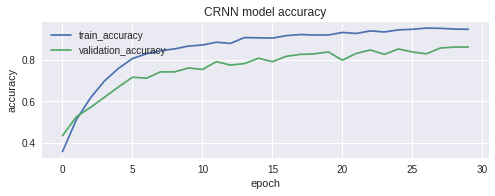

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('CRNN model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

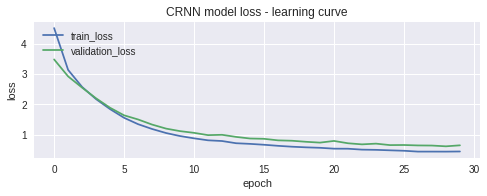

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('CRNN model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

### CRNN-parallel for All Subjects

In [0]:
X_train_valid_all=X_train_valid[0]
for i in np.arange(1,9):
  _,_,X_train_valid[i] = STFT(X_train_crop[i])  
  X_train_valid_all = np.concatenate((X_train_valid_all, X_train_valid[i]), axis=0)
  print(i)  
  print(X_train_valid_all.shape)

new data shape: (2124, 22, 16, 16)
1
(4257, 22, 16, 16)
new data shape: (2124, 22, 16, 16)
2
(6381, 22, 16, 16)
new data shape: (2106, 22, 16, 16)
3
(8487, 22, 16, 16)
new data shape: (2115, 22, 16, 16)
4
(10602, 22, 16, 16)
new data shape: (2124, 22, 16, 16)
5
(12726, 22, 16, 16)
new data shape: (2142, 22, 16, 16)
6
(14868, 22, 16, 16)
new data shape: (2088, 22, 16, 16)
7
(16956, 22, 16, 16)
new data shape: (2079, 22, 16, 16)
8
(19035, 22, 16, 16)


In [0]:
y_train_valid_all=y_train_crop[0]
for i in np.arange(1,9):
  y_train_valid_all = np.concatenate((y_train_valid_all, y_train_crop[i]), axis=0)
  print(i)  
  print(y_train_valid_all.shape)

1
(4257,)
2
(6381,)
3
(8487,)
4
(10602,)
5
(12726,)
6
(14868,)
7
(16956,)
8
(19035,)


In [0]:
y_train_all_onehot = one_hot_matrix(y_train_valid_all)
y_train_all_onehot = y_train_all_onehot.T
N, C, F, T = X_train_valid_all.shape
print("Training data shape: {}".format(X_train_valid_all.shape))


Training data shape: (19035, 22, 16, 16)


In [0]:
model = CRNN_Model(input_shape = (C, F, T))
optimizer = optimizers.Adam(lr=0.02)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x = X_train_valid_all, y = y_train_all_onehot, 
                    epochs = 300, batch_size = 128, 
                    validation_split = 0.2, shuffle = 1, verbose = 1)  

(?, 16, 22, 16)
(?, 16, 352)
Train on 15228 samples, validate on 3807 samples
Epoch 1/300
15228/15228 [==============================] - 11s 736us/sample - loss: 4.1449 - acc: 0.2832 - val_loss: 3.0730 - val_acc: 0.3444
Epoch 2/300
15228/15228 [==============================] - 8s 545us/sample - loss: 2.5778 - acc: 0.3754 - val_loss: 2.3677 - val_acc: 0.3223
Epoch 3/300
15228/15228 [==============================] - 8s 526us/sample - loss: 1.9049 - acc: 0.4270 - val_loss: 1.8223 - val_acc: 0.3635
Epoch 4/300
15228/15228 [==============================] - 8s 512us/sample - loss: 1.5513 - acc: 0.4551 - val_loss: 1.6750 - val_acc: 0.3522
Epoch 5/300
15228/15228 [==============================] - 8s 516us/sample - loss: 1.4100 - acc: 0.4707 - val_loss: 1.5974 - val_acc: 0.4006
Epoch 6/300
15228/15228 [==============================] - 8s 514us/sample - loss: 1.3444 - acc: 0.4852 - val_loss: 1.5609 - val_acc: 0.4064
Epoch 7/300
15228/15228 [==============================] - 8s 522us/sample 

In [0]:
print(X_test[0].shape)
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
preds = model.evaluate(x = X_test[0],y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

(450, 22, 16, 16)
450/450 [==============================] - 0s 794us/sample - loss: 1.5310 - acc: 0.4644
Loss = 1.5310091659757825
Test Accuracy = 0.46444446


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


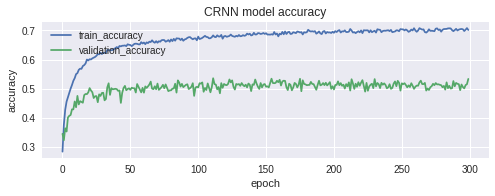

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('CRNN model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

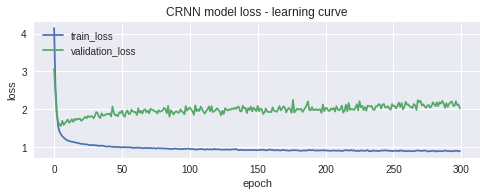

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('CRNN model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

In [0]:
model = CRNN_Model(input_shape = (C, F, T))
optimizer = optimizers.Adam(lr=0.02)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x = X_train_valid_all, y = y_train_all_onehot, 
                    epochs = 100, batch_size = 512, 
                    validation_split = 0.2, shuffle = 1, verbose = 1)  

(?, 16, 22, 16)
(?, 16, 352)
Train on 15228 samples, validate on 3807 samples
Epoch 1/100
15228/15228 [==============================] - 8s 506us/sample - loss: 5.2827 - acc: 0.2720 - val_loss: 4.4743 - val_acc: 0.2958
Epoch 2/100
15228/15228 [==============================] - 3s 223us/sample - loss: 4.0079 - acc: 0.3073 - val_loss: 3.6444 - val_acc: 0.3094
Epoch 3/100
15228/15228 [==============================] - 3s 222us/sample - loss: 3.2893 - acc: 0.3496 - val_loss: 3.1053 - val_acc: 0.3367
Epoch 4/100
15228/15228 [==============================] - 3s 223us/sample - loss: 2.8201 - acc: 0.3817 - val_loss: 2.8389 - val_acc: 0.3107
Epoch 5/100
15228/15228 [==============================] - 3s 225us/sample - loss: 2.4686 - acc: 0.4082 - val_loss: 2.4464 - val_acc: 0.3580
Epoch 6/100
15228/15228 [==============================] - 3s 224us/sample - loss: 2.1914 - acc: 0.4301 - val_loss: 2.2778 - val_acc: 0.3449
Epoch 7/100
15228/15228 [==============================] - 3s 224us/sample -

In [0]:
print(X_test[0].shape)
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
preds = model.evaluate(x = X_test[0],y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

(450, 22, 16, 16)
450/450 [==============================] - 0s 834us/sample - loss: 1.1065 - acc: 0.5556
Loss = 1.1064685000313652
Test Accuracy = 0.5555556


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


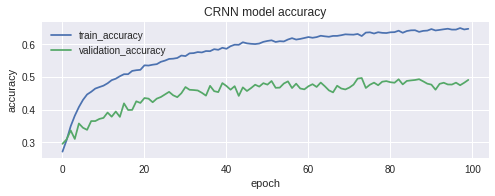

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('CRNN model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

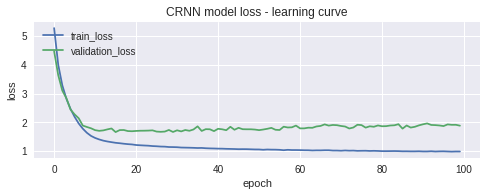

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('CRNN model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')



*   With CRNN parallel, the result is good for one subject but not good for combined dataset
*   The intuition behind using CRNN is that, using CNN to convolute over electrode and time, since CNN is good at spatial tensor. And RNN is good at temporal tensor so transpose and reshape the data and use RNN to analyze time series component.
*   For CRNN-cascade, the data is firstly fed to CNN, then reshaped and fed to RNN. The structure is more complicated, so needs more time to train for each epoch. (The time-limited step is at RNN, so before fed into RNN, the flattened tensor needs to go through two dense layer to reduce the neuron number)
*   For CRNN-parallel, the data is fed to CNN and RNN at the same time, and then concatenate the output tensors in parallel before going to the softmax for classification.
*   Reason might be firstly the combined datasets might have subjects that acts like outliers behaving differently
*   We are combining the CNN and RNN, but using the same batch size and learning rate for the training, these hyperparameters might not be the best for them
*   Normally for the batch size is 32, 64, 128 ,512 (if we continue increase the batch size, the GPU will not be compatible with that and leading to the failure of converge). Larger datasets means more iteration per epoch, leading to the overfitting.


## Tuning

### Tune Dropout Rate

In [0]:
def CRNN_Model(input_shape, dropout_rate):
  tf.set_random_seed(2)
  np.random.seed(2)
  
  # CNN
  X_input = Input(input_shape)  
  X = Conv2D(filters = 22, kernel_size = (3, 3), strides = (1, 1), kernel_regularizer=regularizers.l1(0.01), 
                   name = 'conv0', data_format='channels_last')(X_input)
  X = Conv2D(filters= 44, kernel_size = (3, 3), strides = (1, 1), name = 'conv1', data_format='channels_last', 
                   padding='valid', kernel_regularizer=regularizers.l2(0.01))(X) 
  X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'mean_pool')(X)
  X = ELU()(X)
  #X = BatchNormalization()(X)
  X = Dropout(dropout_rate)(X)
  X = Flatten()(X)
  
  # RNN  
  XR_input = X_input #(2133, 22, 16, 16)(N, n_electrode, f, t)
  XR = Permute((3,1,2))(XR_input)
  print(XR.shape)
  XR = Reshape((XR.shape[1], XR.shape[2]*XR.shape[3]))(XR)
  print(XR.shape)
  XR = LSTM(units = 32, return_sequences = False, kernel_regularizer=regularizers.l2(0.01))(XR)    
  XR = Dropout(dropout_rate, seed = 0)(XR)  
  
  # Concatenate tensor  
  X_out = Concatenate()([X, XR])  
  X_out = Dense(units = 4, activation='softmax', name='fc2')(X_out)
  
  model = Model(inputs = X_input, outputs = X_out, name='CRNN_Model')  
  
  return model

In [0]:
# define the search parameters
np.random.seed(0)
dropout_rate_r = -1*np.random.rand(10)
dropout_rate = 10**dropout_rate_r
dropout_rate.sort()
print(dropout_rate)

[0.10872696 0.1283001  0.19266846 0.22599867 0.24959543 0.28260933
 0.28517852 0.3651008  0.37700334 0.413579  ]


In [0]:
# for loop search
rate_acc_list = []

for rate_iter in dropout_rate:
  start = time.time()
  model = CRNN_Model(input_shape = (C, F, T), dropout_rate = rate_iter)
  optimizer = optimizers.Adam(lr=0.2)
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])    
  model.fit(x = X_train_valid[0], y = y_train_onehot, 
                  epochs = 30, batch_size = 32, 
                  validation_split = 0.2, verbose = 0)
  end = time.time()
  preds = model.evaluate(x = X_test[0],y = y_test_onehot)
  rate_acc_list.append(preds[1])

(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 671us/sample - loss: 1.2078 - acc: 0.6444
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 680us/sample - loss: 1.2075 - acc: 0.6089
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 661us/sample - loss: 1.1222 - acc: 0.6467
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 683us/sample - loss: 1.2662 - acc: 0.5844
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 655us/sample - loss: 1.1913 - acc: 0.6200
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 662us/sample - loss: 1.1718 - acc: 0.6378
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 662us/sample - loss: 1.2454 - acc: 0.6200
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 676us/sample - loss: 1.1761 - acc: 0.6444
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==========================

In [0]:
print(rate_acc_list)

[0.64444447, 0.60888886, 0.64666665, 0.58444446, 0.62, 0.6377778, 0.62, 0.64444447, 0.66444445, 0.64666665]


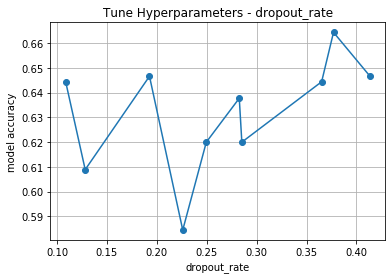

In [0]:
# visulization
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(dropout_rate,rate_acc_list,'-o')
plt.xlabel('dropout_rate')
plt.ylabel('model accuracy')
plt.title('Tune Hyperparameters - dropout_rate')
plt.grid()
plt.show()


### Tune Units Number and L2 Regularization

In [0]:
def CRNN_Model(input_shape, units_num = 32, rnn_l2 = 0.01):
  tf.set_random_seed(2)
  np.random.seed(2)
  
  # CNN
  X_input = Input(input_shape)  
  X = Conv2D(filters = 22, kernel_size = (3, 3), strides = (1, 1), kernel_regularizer=regularizers.l1(0.01), 
                   name = 'conv0', data_format='channels_last')(X_input)
  X = Conv2D(filters= 44, kernel_size = (3, 3), strides = (1, 1), name = 'conv1', data_format='channels_last', 
                   padding='valid', kernel_regularizer=regularizers.l2(0.01))(X) 
  X = MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = 'mean_pool')(X)
  X = ELU()(X)
  #X = BatchNormalization()(X)
  X = Dropout(0.38)(X)
  X = Flatten()(X)
  
  # RNN  
  XR_input = X_input #(2133, 22, 16, 16)(N, n_electrode, f, t)
  XR = Permute((3,1,2))(XR_input)
  print(XR.shape)
  XR = Reshape((XR.shape[1], XR.shape[2]*XR.shape[3]))(XR)
  print(XR.shape)
  XR = LSTM(units = units_num, return_sequences = False, kernel_regularizer=regularizers.l2(rnn_l2))(XR)    
  XR = Dropout(0.38, seed = 0)(XR)  
  
  # Concatenate tensor  
  X_out = Concatenate()([X, XR])  
  X_out = Dense(units = 4, activation='softmax', name='fc2')(X_out)
  
  model = Model(inputs = X_input, outputs = X_out, name='CRNN_Model')  
  
  return model

In [0]:
# define the search parameters
np.random.seed(0)
l2r = -3*np.random.rand(5)
rnn_l2_array = 10**l2r
rnn_l2_array.sort()
units_num_array = [32, 64, 128, 512]
print(units_num_array)
print(rnn_l2_array)

[32, 64, 128, 512]
[0.00715207 0.01554927 0.02257145 0.02319265 0.05358406]


In [0]:
# for loop search
unit_l2_acc_list = []              
                     
for u_iter in units_num_array:
  for l2_iter in rnn_l2_array:
    model = CRNN_Model(input_shape = (C, F, T), units_num = u_iter, rnn_l2 = l2_iter) 
    optimizer = optimizers.Adam(lr=0.2)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
    model.fit(x = X_train_valid[0], y = y_train_onehot, 
                  epochs = 30, batch_size = 32, 
                  validation_split = 0.2, verbose = 0) 
    preds = model.evaluate(x = X_test[0],y = y_test_onehot)
    unit_l2_acc_list.append(preds[1])


(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 673us/sample - loss: 1.1764 - acc: 0.6289
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 678us/sample - loss: 1.1586 - acc: 0.6378
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 684us/sample - loss: 1.2740 - acc: 0.6289
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 733us/sample - loss: 1.1678 - acc: 0.6311
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 706us/sample - loss: 1.2499 - acc: 0.5956
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 709us/sample - loss: 1.1871 - acc: 0.6511
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 690us/sample - loss: 1.1738 - acc: 0.6400
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==============================] - 0s 689us/sample - loss: 1.1858 - acc: 0.6333
(?, 16, 22, 16)
(?, 16, 352)
450/450 [==========================

In [0]:
print(unit_l2_acc_list)

[0.6288889, 0.6377778, 0.6288889, 0.6311111, 0.59555554, 0.6511111, 0.64, 0.6333333, 0.6577778, 0.64, 0.62, 0.68666667, 0.64444447, 0.6933333, 0.62222224, 0.6333333, 0.6, 0.6022222, 0.6533333, 0.6511111]


<Figure size 720x720 with 0 Axes>

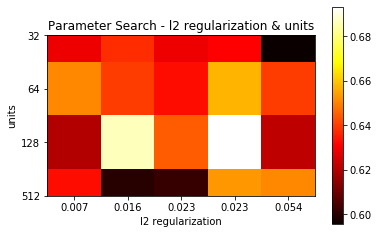

In [0]:
# visulization
ul2_acc_array = np.array(unit_l2_acc_list)
ul2_acc_array = ul2_acc_array.reshape(len(units_num_array), len(rnn_l2_array))
my_formatted_rnn_l2 = [ '%.3f' % elem for elem in rnn_l2_array ]

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.imshow(ul2_acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('l2 regularization')
plt.ylabel('units')
plt.colorbar()
plt.xticks(np.arange(len(l2)), my_formatted_rnn_l2)
plt.yticks(np.arange(len(units)), units_num_array)
plt.title('Parameter Search - l2 regularization & units')
plt.show()

In [0]:
unit_l2_acc_list = [0.6288889, 0.6377778, 0.6288889, 0.6311111, 0.59555554, 0.6511111, 0.64, 0.6333333, 0.6577778, 0.64, 0.62, 0.68666667, 0.64444447, 0.6933333, 0.62222224, 0.6333333, 0.6, 0.6022222, 0.6533333, 0.6511111]

In [0]:
units_num_array = [32, 64, 128, 512]
rnn_l2_array = [0.00715207, 0.01554927, 0.02257145, 0.02319265, 0.05358406]

<Figure size 720x720 with 0 Axes>

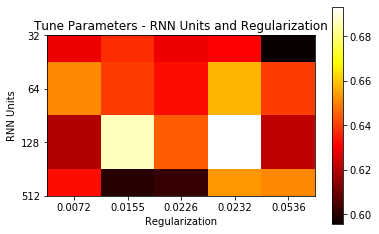

In [0]:
# visulization
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

ul2_acc_array = np.array(unit_l2_acc_list)
ul2_acc_array = ul2_acc_array.reshape(len(units_num_array), len(rnn_l2_array))
my_formatted_rnn_l2 = [ '%.4f' % elem for elem in rnn_l2_array ]

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.imshow(ul2_acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('Regularization')
plt.ylabel('RNN Units')
plt.colorbar()
plt.xticks(np.arange(len(my_formatted_rnn_l2)), my_formatted_rnn_l2)
plt.yticks(np.arange(len(units_num_array)), units_num_array)
plt.title('Tune Parameters - RNN Units and Regularization')
plt.show()

## CNN

## RNN

## Naive RNN

### Data Prepocessing for RNN

In [0]:
print('Training data shape after cropping and STFT {}'.format(X_train_valid[0].shape))

Training data shape after cropping and STFT (2133, 22, 16, 16)


In [0]:
# transpose the data so that the the shape is [#sample, time_seq, feature1, feature2]
X_train_valid_0_transpose = np.transpose(X_train_valid[0], (0,2,1,3))
print('Training data shape after transpose {}'.format(X_train_valid_0_transpose.shape))

# reshape the data to compress the features into one dimension
X_train_valid_0_transpose_reshape = X_train_valid_0_transpose.reshape(2133, 16, -1)
print('Training data shape after reshape {}'.format(X_train_valid_0_transpose_reshape.shape))


Training data shape after transpose (2133, 16, 22, 16)
Training data shape after reshape (2133, 16, 352)


In [0]:
print('Testing data shape {}'.format(X_test[0].shape))

# transpose the data so that the the shape is [#sample, time_seq, feature1, feature2]
X_test_0_transpose = np.transpose(X_test[0], (0,2,1,3))
print('Testing data shape after transpose {}'.format(X_test_0_transpose.shape))

# reshape the data to compress the features into one dimension
X_test_0_transpose_reshape = X_test_0_transpose.reshape(450,16,-1)
print('Testing data shape after reshape {}'.format(X_test_0_transpose_reshape.shape))


Testing data shape (450, 22, 16, 16)
Testing data shape after transpose (450, 16, 22, 16)
Testing data shape after reshape (450, 16, 352)


### Training and Modeling

In [0]:
def one_hot_matrix(labels, C=4):
    transformed_labels = labels - 769
    C = tf.constant(C, name = "C")
    one_hot_matrix = tf.one_hot(transformed_labels, depth = C, axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [0]:
# Choose set of training data
subject_num = 0
y_train_onehot = one_hot_matrix(y_train_valid[subject_num])
y_train_onehot = y_train_onehot.T
N, C, F, T = X_train_valid[subject_num].shape
print("Training data shape: {}".format(X_train_valid[subject_num].shape))

def stft_RNN_Model():
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 32, return_sequences = True))    
    model.add(Dropout(0.5, seed = 0))    
    model.add(LSTM(units = 64, return_sequences = False))
    model.add(Dense(units = 4, activation = 'sigmoid'))
    optimizer = optimizers.RMSprop(lr=1)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])	  
    return model

Training data shape: (2133, 22, 16, 16)


In [0]:
print(X_train_valid[0].shape)

(2133, 22, 16, 16)


In [0]:
# transpose the data so that the the shape is [#sample, time_seq, feature1, feature2]
X_train_valid_0_transpose = np.transpose(X_train_valid[0], (0,2,1,3))
print(X_train_valid_0_transpose.shape)

(2133, 16, 22, 16)


In [0]:
# reshape the data to compress the features into one dimension
X_train_valid_0_transpose_reshape = X_train_valid_0_transpose.reshape(2133, 16, -1)
print(X_train_valid_0_transpose_reshape.shape)

(2133, 16, 352)


In [0]:
model = stft_RNN_Model()
history = model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                    epochs = 30, batch_size = 20, 
                    validation_split = 0.2, verbose = 1)  

Train on 1706 samples, validate on 427 samples
Epoch 1/30
1706/1706 [==============================] - 19s 11ms/sample - loss: 1.3904 - acc: 0.2661 - val_loss: 1.3894 - val_acc: 0.2342
Epoch 2/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.3822 - acc: 0.2743 - val_loss: 1.3815 - val_acc: 0.2389
Epoch 3/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.3707 - acc: 0.2878 - val_loss: 1.3852 - val_acc: 0.2529
Epoch 4/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.3527 - acc: 0.3183 - val_loss: 1.3655 - val_acc: 0.3162
Epoch 5/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.3394 - acc: 0.3529 - val_loss: 1.3661 - val_acc: 0.3208
Epoch 6/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.3050 - acc: 0.3693 - val_loss: 1.4313 - val_acc: 0.3091
Epoch 7/30
1706/1706 [==============================] - 15s 9ms/sample - loss: 1.2903 - acc: 0.3834 - val_loss: 1.4066 - val_acc: 

### Testing

In [0]:
#X_train_0 = X_train_valid[0].reshape(X_train_valid[0].shape[0],X_train_valid[0].shape[2],-1)
print(X_test[0].shape)
#X_test_reshape = X_test[0].reshape(X_test[0].shape[0], X_test[0].shape[2], -1)
X_test_0_transpose = np.transpose(X_test[0], (0,2,1,3))
print(X_test_0_transpose.shape)

(450, 22, 16, 16)
(450, 16, 22, 16)


In [0]:
X_test_0_transpose_reshape = X_test_0_transpose.reshape(450,16,-1)
print(X_test_0_transpose_reshape.shape)

(450, 16, 352)


In [0]:
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T

In [0]:
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
#X_test[0] = X_test[0].reshape(X_test[0].shape[0],X_test[0].shape[2],-1)
preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

450/450 [==============================] - 1s 3ms/sample - loss: 1.9310 - acc: 0.3333
Loss = 1.9309590491983626
Test Accuracy = 0.33333334


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


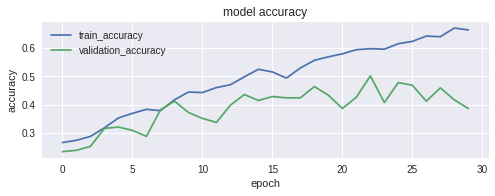

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left') 

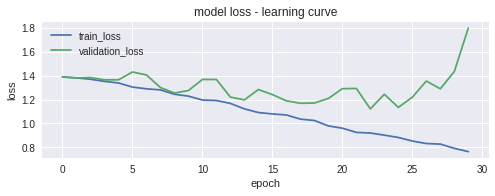

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')  

In [0]:
def stft_RNN_Model():
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 32, return_sequences = False, kernel_regularizer=regularizers.l2(0.01)))    
    model.add(Dropout(0.5, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=0.2)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
model = stft_RNN_Model()
history = model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                    epochs = 100, batch_size = 200, 
                    validation_split = 0.2, verbose = 1) 

Train on 1706 samples, validate on 427 samples
Epoch 1/100
1706/1706 [==============================] - 2s 1ms/sample - loss: 3.2518 - acc: 0.2773 - val_loss: 3.0638 - val_acc: 0.2436
Epoch 2/100
1706/1706 [==============================] - 1s 448us/sample - loss: 2.9717 - acc: 0.2726 - val_loss: 2.8264 - val_acc: 0.2857
Epoch 3/100
1706/1706 [==============================] - 1s 447us/sample - loss: 2.7509 - acc: 0.2585 - val_loss: 2.6190 - val_acc: 0.2787
Epoch 4/100
1706/1706 [==============================] - 1s 461us/sample - loss: 2.5339 - acc: 0.2954 - val_loss: 2.4283 - val_acc: 0.3232
Epoch 5/100
1706/1706 [==============================] - 1s 452us/sample - loss: 2.3661 - acc: 0.2825 - val_loss: 2.2646 - val_acc: 0.2951
Epoch 6/100
1706/1706 [==============================] - 1s 454us/sample - loss: 2.2053 - acc: 0.2925 - val_loss: 2.1245 - val_acc: 0.2881
Epoch 7/100
1706/1706 [==============================] - 1s 459us/sample - loss: 2.0719 - acc: 0.3013 - val_loss: 2.0103 

In [0]:
y_test_onehot = one_hot_matrix(y_test[0], C = 4)
y_test_onehot = y_test_onehot.T
#X_test[0] = X_test[0].reshape(X_test[0].shape[0],X_test[0].shape[2],-1)
preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

450/450 [==============================] - 0s 718us/sample - loss: 1.3038 - acc: 0.5000
Loss = 1.3037719927893745
Test Accuracy = 0.5


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


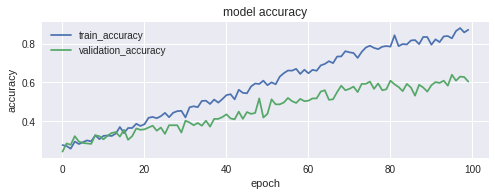

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left') 

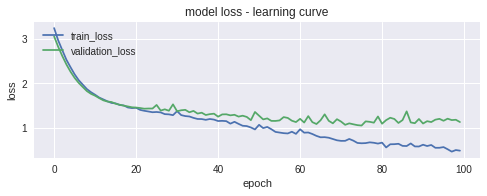

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')  

#### Tune Learning Rate and Batch Size

In [0]:
def stft_RNN_Model(lr=0.2):
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 32, return_sequences = False, kernel_regularizer=regularizers.l2(0.01)))    
    model.add(Dropout(0.5, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
# define the search parameters
np.random.seed(0)
r = -3*np.random.rand(5)
lr = 10**r
lr.sort()
batch_size = [64, 128, 256, 512, 1024]
print(lr)

[0.00715207 0.01554927 0.02257145 0.02319265 0.05358406]


In [0]:
# for loop search
acc_list = []              
                     
for lr_iter in lr:
  for batch_iter in batch_size:
    model = stft_CRNN_Model(lr=lr_iter)    
    model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                    epochs = 100, batch_size = batch_iter, 
                    validation_split = 0.2, verbose = 0)
    preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)
    acc_list.append(preds[1])


450/450 [==============================] - 0s 754us/sample - loss: 1.4522 - acc: 0.3844


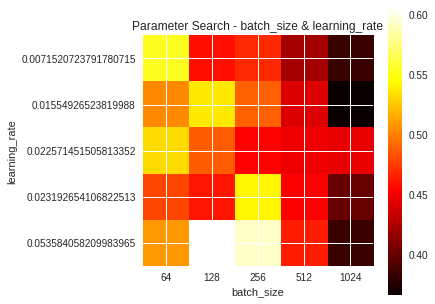

In [0]:
# visualization
acc_array = np.array(acc_list)
acc_array = acc_array.reshape(len(lr), len(batch_size))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
plt.imshow(acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('batch_size')
plt.ylabel('learning_rate')
plt.colorbar()
plt.xticks(np.arange(len(batch_size)), batch_size)
plt.yticks(np.arange(len(lr)), lr)
plt.title('Parameter Search - batch_size & learning_rate')
plt.show()

In [0]:
# save to a file
with open('acc_array_file.txt','wb') as f:
    for line in acc_array:
        np.savetxt(f, line, fmt='%.2f')

In [0]:
np.random.seed(0)
r = -3*np.random.rand(5)
lr = 10**r
lr.sort()
batch_size = [64, 128, 256, 512, 1024]
print(lr)
formatted_lr = ["%.4f"%item for item in lr]
print(formatted_lr)

[0.00715207 0.01554927 0.02257145 0.02319265 0.05358406]
['0.0072', '0.0155', '0.0226', '0.0232', '0.0536']


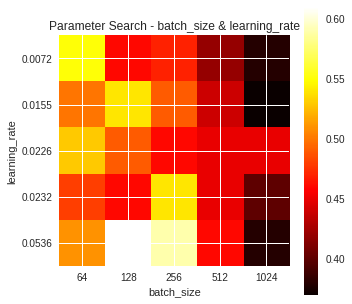

In [0]:
# reopen the saved file
acc_list=[]
with open('acc_array_file.txt') as f:
  for line in f:
    acc_list.extend([float(i) for i in line.split()])
    
# visualization

acc_array = np.array(acc_list)
acc_array = acc_array.reshape(len(formatted_lr), len(batch_size))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
plt.imshow(acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('batch_size')
plt.ylabel('learning_rate')
plt.colorbar()
plt.xticks(np.arange(len(batch_size)), batch_size)
plt.yticks(np.arange(len(formatted_lr)), formatted_lr)
plt.title('Parameter Search - batch_size & learning_rate')
plt.show()

#### Tune Units Number and L2 Regularization

In [0]:
def stft_RNN_Model(units = 32, l2 = 0.01):
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = units, return_sequences = False, kernel_regularizer=regularizers.l2(l2)))    
    model.add(Dropout(0.5, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=0.05)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
# define the search parameters
np.random.seed(0)
l2r = -2*np.random.rand(5)
l2 = 10**r
l2.sort()
units = [32, 64, 128, 512]
print(l2)

[0.00715207 0.01554927 0.02257145 0.02319265 0.05358406]


In [0]:
# for loop search
ul2_acc_list = []              
                     
for u_iter in units:
  for l2_iter in l2:
    model = stft_RNN_Model(units=u_iter, l2=l2_iter)    
    model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                    epochs = 100, batch_size = 128, 
                    validation_split = 0.2, verbose = 0)
    preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)
    ul2_acc_list.append(preds[1])

450/450 [==============================] - 0s 779us/sample - loss: 1.1933 - acc: 0.5756


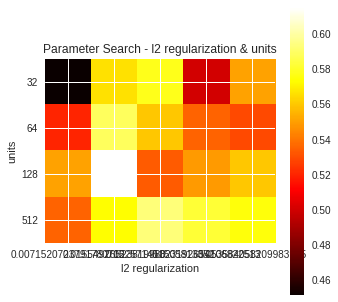

In [0]:
# visulization
ul2_acc_array = np.array(ul2_acc_list)
ul2_acc_array = ul2_acc_array.reshape(len(units), len(l2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
plt.imshow(ul2_acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('l2 regularization')
plt.ylabel('units')
plt.colorbar()
plt.xticks(np.arange(len(l2)), l2)
plt.yticks(np.arange(len(units)), units)
plt.title('Parameter Search - l2 regularization & units')
plt.show()

In [0]:
# save to a file
with open('ul2_acc_array_file.txt','wb') as f:
    for line in ul2_acc_array:
        np.savetxt(f, line, fmt='%.2f')

In [0]:
np.random.seed(0)
l2r = -2*np.random.rand(5)
l2 = 10**r
l2.sort()
units = [32, 64, 128, 512]
print(l2)
formatted_l2 = ["%.4f"%item for item in l2]
print(formatted_l2)

[0.00715207 0.01554927 0.02257145 0.02319265 0.05358406]
['0.0072', '0.0155', '0.0226', '0.0232', '0.0536']


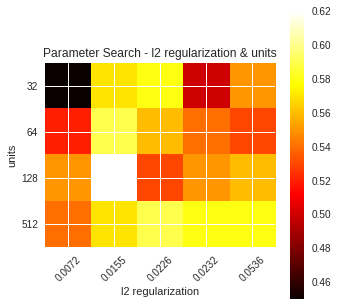

In [0]:
# reopen the saved file
ul2_acc_list=[]
with open('ul2_acc_array_file.txt') as f:
  for line in f:
    ul2_acc_list.extend([float(i) for i in line.split()])
    
# visualization

ul2_acc_array = np.array(ul2_acc_list)
ul2_acc_array = ul2_acc_array.reshape(len(units), len(formatted_l2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=0.6, bottom=0.2, right=0.6, left=0.2)
plt.imshow(ul2_acc_array, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('l2 regularization')
plt.ylabel('units')
plt.colorbar()
plt.xticks(np.arange(len(formatted_l2)), formatted_l2, rotation=45)
plt.yticks(np.arange(len(units)), units)
plt.title('Parameter Search - l2 regularization & units')
plt.show()

#### Tune Dropout Rate

In [0]:
def stft_RNN_Model(dropout_rate=0.5):
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 128, return_sequences = False, kernel_regularizer=regularizers.l2(0.02)))    
    model.add(Dropout(rate=dropout_rate, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=0.05)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
# define the search parameters
np.random.seed(0)
dropout_rate_r = -1*np.random.rand(5)
dropout_rate = 10**dropout_rate_r
dropout_rate.sort()
print(dropout_rate)

[0.19266846 0.24959543 0.28260933 0.28517852 0.37700334]


In [0]:
# for loop search
rate_acc_list = []

for rate_iter in dropout_rate:
  model = stft_CRNN_Model(dropout_rate = rate_iter)    
  model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                  epochs = 100, batch_size = 128, 
                  validation_split = 0.2, verbose = 0)
  preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)
  rate_acc_list.append(preds[1])

450/450 [==============================] - 0s 718us/sample - loss: 1.4329 - acc: 0.6222


In [0]:
print(rate_acc_list)

[0.52, 0.52666664, 0.54888886, 0.62222224, 0.62222224]


In [0]:
# save to a file
with open('rate_acc_array_file.txt','wb') as f:    
      np.savetxt(f, rate_acc_list, fmt='%.2f')

Text(0.5, 1.0, 'Parameter Search - dropout_rate')

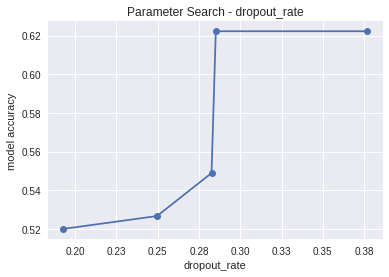

In [0]:
# visulization
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(dropout_rate,rate_acc_list,'-o')
plt.xlabel('dropout_rate')
plt.ylabel('model accuracy')
plt.title('Parameter Search - dropout_rate')



#### Tune Optimizer

In [0]:
def stft_RNN_Model():
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 128, return_sequences = False, kernel_regularizer=regularizers.l2(0.02)))    
    model.add(Dropout(rate=0.38, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.RMSprop(lr=0.05)
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])	  
    return model

In [0]:
model = stft_RNN_Model()    
history = model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                epochs = 100, batch_size = 128, 
                validation_split = 0.2, verbose = 0)
preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)

450/450 [==============================] - 0s 712us/sample - loss: 1.2619 - acc: 0.4756


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


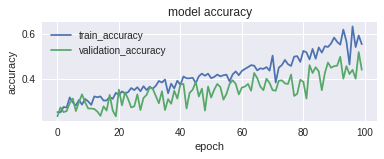

In [0]:
print(history.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

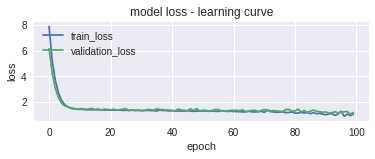

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')  

#### Tune Struction - Add LSTM Layer

In [0]:
def stft_RNN_Model():
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 128, return_sequences = True, kernel_regularizer=regularizers.l2(0.02)))
    model.add(LSTM(units = 128, return_sequences = False, kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(rate=0.38, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=0.05)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
model = stft_RNN_Model()    
history_addLayer = model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                epochs = 100, batch_size = 128, 
                validation_split = 0.2, verbose = 0)
preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)

450/450 [==============================] - 1s 1ms/sample - loss: 2.0389 - acc: 0.5200


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


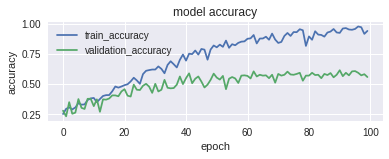

In [0]:
print(history_addLayer.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history_addLayer.history['acc'])  
plt.plot(history_addLayer.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

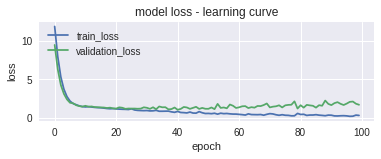

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history_addLayer.history['loss'])  
plt.plot(history_addLayer.history['val_loss'])  
plt.title('model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

### Optimized Naive RNN Learning Curve

In [0]:
def stft_RNN_Model():
    np.random.seed(0)
    tf.set_random_seed(1)
    model = Sequential()    
    model.add(LSTM(units = 128, return_sequences = False, kernel_regularizer=regularizers.l2(0.02)))    
    model.add(Dropout(rate=0.38, seed = 0))    
    model.add(Dense(units = 4, activation = 'softmax'))
    optimizer = optimizers.Adam(lr=0.05)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])	  
    return model

In [0]:
model = stft_RNN_Model()    
history_optimize = model.fit(x = X_train_valid_0_transpose_reshape, y = y_train_onehot, 
                epochs = 100, batch_size = 128, 
                validation_split = 0.2, verbose = 0)
preds = model.evaluate(x = X_test_0_transpose_reshape,y = y_test_onehot)

450/450 [==============================] - 0s 720us/sample - loss: 1.6624 - acc: 0.5911


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


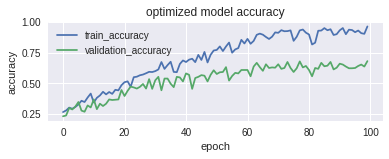

In [0]:
print(history_optimize.history.keys())  
   
plt.figure(1)  

plt.subplot(211)  
plt.plot(history_optimize.history['acc'])  
plt.plot(history_optimize.history['val_acc'])  
plt.title('optimized model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train_accuracy', 'validation_accuracy'], loc='upper left')

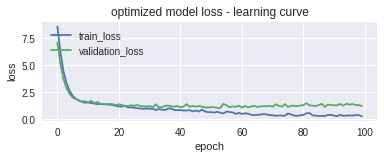

In [0]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history_optimize.history['loss'])  
plt.plot(history_optimize.history['val_loss'])  
plt.title('optimized model loss - learning curve')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train_loss', 'validation_loss'], loc='upper left')



*   Cropping is a data augmentation method to increase sample number, the data is cropped and stacked together to form a larger dataset, and each sliding window for the cropping have overlapping with each other so as to keep the data related and dependent
*   STFT obtains the frequency of the time series data, adding more features to the dataset, the frequency of the STFT data is cropped so as to reduce the noise
*   LSTM use forgetting gate, writing gate and reading gate to "memorize" the previous state, the data needs to have the dimension of (#sample, time_seq, n_feature) to feed into the Keras LSTM layer,  so as to make good use of LSTM
*   Batch size near the number of training sample performs better
*   Simpler structure with less layers could reduce overfitting, because each LSTM layer has a lot of parameters due to the forgetting gate, writing gate and reading gate in each LSTM cell
*   Add L2 regularization to reduce overfitting
*   From the learning curve we could determine the approximate range for the learning rate (1) if the loss increase with epoch, the learning rate is too large (2) if the accuracy and the validation are similar but they both keep increasing, the learning rate is too small 
*   The activation function of the LSTM layer does not need to be tuned, the sigmoid function is used for the recurrent activation because the the gate value is between 0 and 1,  the tanh function is used for the activation because the derivative of it is larger than sigmoid so the weight could have larger update to learn faster, also tanh function could solve the vanishing gradient for its derivative is not zero